In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import snntorch

import matplotlib.pyplot as plt
import seaborn as sns

from statistics import mean, stdev
from sklearn.metrics import confusion_matrix, accuracy_score
from importnb import Notebook
import tqdm
import copy

In [2]:
with Notebook():
    from Preprocessing import *

In [3]:
data.shape, labels.shape

(torch.Size([9315, 6, 4096]), torch.Size([9315, 3]))

In [4]:
data = common_average_referencing(normalize(data, dim=2), dim=1)
classes = labels[:, 1]

In [5]:
mask1 = labels[:, 0] == modalities.index("Imagined")
mask2 = labels[:, 2] == artifacts.index("None")
mask3 = labels[:, 1] <= stimuli.index("U")
mask = mask1 & mask2 & mask3

In [6]:
# Make training and test sets. 60% 20% 20% split.
torch.manual_seed(42)
half = torch.rand_like(mask, dtype=torch.float) < 0.5
train_mask = mask & (torch.rand_like(mask, dtype=torch.float) < 0.6)
valid_mask = mask & ~train_mask & half
test_mask = mask & ~train_mask & ~half

In [7]:
batch_size = 23
epochs = 21
layers = 4
hidden_size = 931
gain = 1.7665978499606967
bias = 0.12368332059804911
lr =  0.00043311422013922235
bin_size = 16
runs = 16

In [8]:
spikes = bin_sum(delta_coding(data, delta=0.1), bin_size)

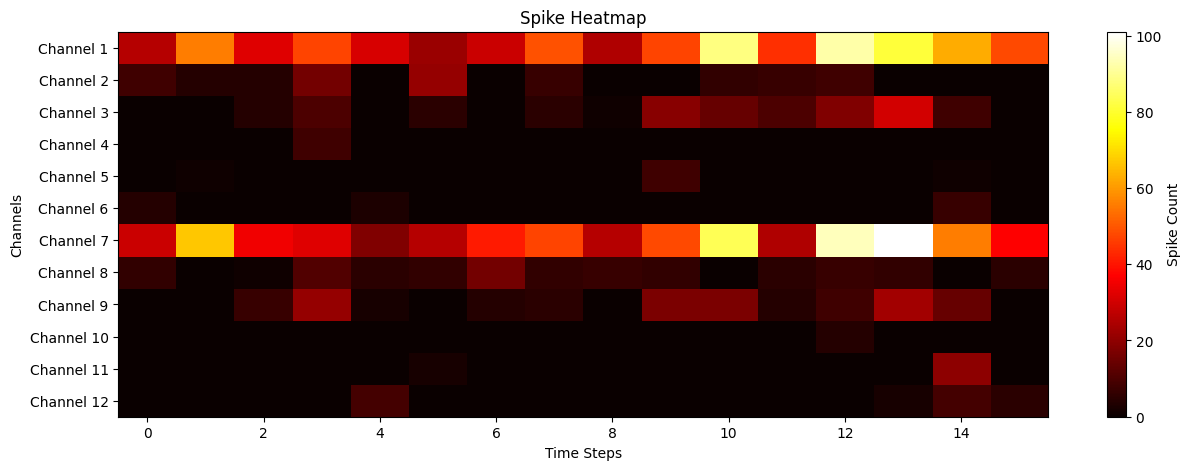

In [9]:
plt.figure(figsize=(15, 5))
plt.imshow(spikes[train_mask][0].numpy(), aspect='auto', cmap='hot', interpolation='nearest')
plt.colorbar(label='Spike Count')
plt.xlabel('Time Steps')
plt.ylabel('Channels')
plt.title('Spike Heatmap')
plt.yticks(range(spikes.size(1)), [f'Channel {i+1}' for i in range(spikes.size(1))])
plt.show()

In [10]:
loader = DataLoader(TensorDataset(spikes[train_mask], classes[train_mask]), batch_size=batch_size, collate_fn=collate)
valid_loader = DataLoader(TensorDataset(spikes[valid_mask], classes[valid_mask]), batch_size=batch_size, collate_fn=collate)
test_loader = DataLoader(TensorDataset(spikes[test_mask], classes[test_mask]), batch_size=batch_size, collate_fn=collate)

In [11]:
class LifParClassifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, layers=2, gain=10, bias=1):
        super().__init__()
        sizes = [(input_size, hidden_size)] + [(hidden_size, hidden_size)] * (layers-2) + [(hidden_size, output_size)]
        self.lifs = torch.nn.ModuleList([snntorch.LeakyParallel(in_size,
                                                                out_size,
                                                                learn_threshold=True,
                                                                learn_beta=True) for in_size, out_size in sizes])

        for name, param in self.named_parameters():
            if 'weight' in name:
                torch.nn.init.xavier_normal_(param, gain=gain)
            elif 'bias' in name:
                torch.nn.init.constant_(param, bias)
            
    def forward(self, x):
        for lif in self.lifs:
            x = lif(x)             
        return x

In [12]:
# Coutesty of o1.
def add_undecided(logits, dim=1):
    """
    Adds an extra column to the logits tensor. The column has a value of 1
    for rows where all values are equal, and 0 otherwise.

    Args:
        logits (torch.Tensor): Input tensor of logits.
        dim (int): Dimension along which to check equality.

    Returns:
        torch.Tensor: Logits tensor with an additional column.
    """
    all_equal = (torch.diff(logits, dim=dim) == 0).all(dim=dim, keepdim=True)
    undecided_column = all_equal.float()
    return torch.cat([logits, undecided_column], dim=dim)

In [13]:
epics = []
for run in range(runs):
    net = LifParClassifier(input_size=spikes.size(1),
                           hidden_size=hidden_size,
                           output_size=5,
                           layers=layers,
                           gain=gain,
                           bias=bias)
    optimizer = torch.optim.Adagrad(net.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    losses = []
    valid_losses = []
    progress = tqdm.tqdm(range(epochs), unit="epoch")
    for epoch in progress:
        batch_losses = []
        net.train()    
        for events, targets in loader:
            optimizer.zero_grad()
            spk = net(events)
            logits = add_undecided(spk.sum(dim=0))
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()
            batch_losses += [loss.item()]
    
        valid_batch_losses = []
        net.eval()
        with torch.no_grad():
            for events, targets in valid_loader:
                spk = net(events)
                logits = add_undecided(spk.sum(dim=0))
                loss = criterion(logits, targets)
                valid_batch_losses += [loss.item()]
                
        losses += [mean(batch_losses)]
        valid_losses += [mean(valid_batch_losses)]
    
        if valid_losses[-1] == min(valid_losses):
            epic = copy.deepcopy(net.state_dict())
        
        progress.set_description(f'Loss: {losses[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f},')
    epics += [epic]

Loss: 1.6144, Validation Loss: 1.9124,: 100%|██████████| 21/21 [00:54<00:00,  2.61s/epoch]


Accuaracy M: 0.20087594696969696 SD: 0.022679545319581898


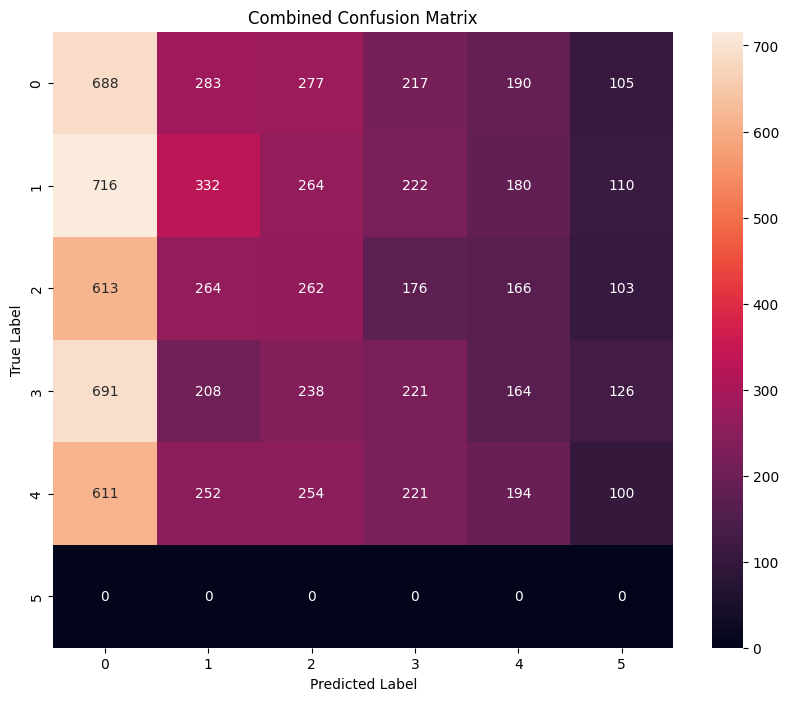

In [14]:
scores = []
for epic in epics:
    net.load_state_dict(epic)
    net.eval()
    valid_predictions = []
    valid_targets = []
    with torch.no_grad():
        for events, targets in valid_loader:
            spk = net(events)
            logits = add_undecided(spk.sum(dim=0))
            predictions = torch.argmax(logits, dim=1)
            valid_predictions += predictions.tolist()
            valid_targets += targets.tolist()
    scores += [(valid_targets, valid_predictions)]

accuracies = [accuracy_score(*score) for score in scores]
print("Accuaracy M:", mean(accuracies), "SD:", stdev(accuracies))

cm = confusion_matrix(*(sum(lst, []) for lst in zip(*scores)))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Combined Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Accuaracy M: 0.18461538461538463 SD: 0.025522160382919


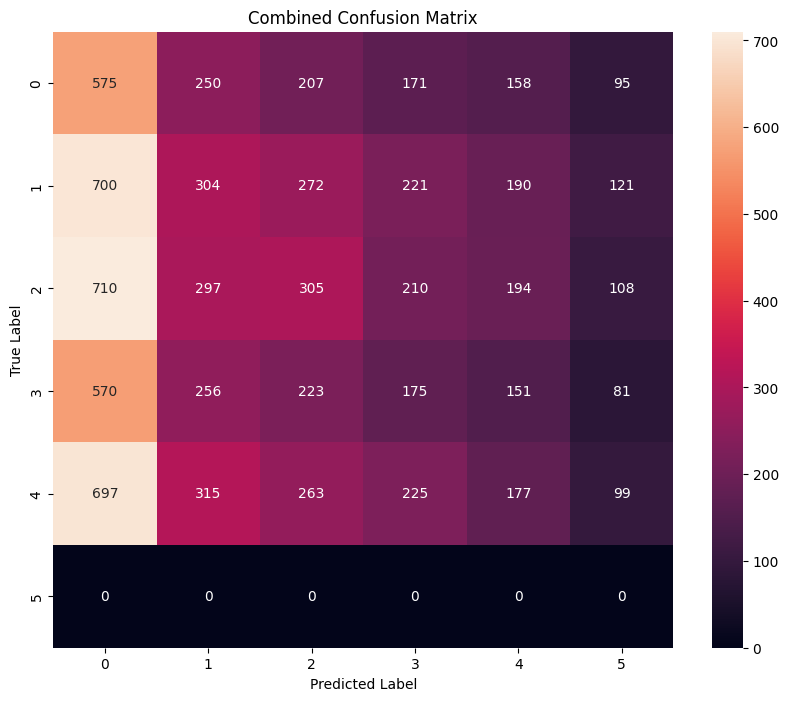

In [15]:
scores = []
for epic in epics:
    net.load_state_dict(epic)
    net.eval()
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for events, targets in test_loader:
            spk = net(events)
            logits = add_undecided(spk.sum(dim=0))
            predictions = torch.argmax(logits, dim=1)
            test_predictions += predictions.tolist()
            test_targets += targets.tolist()
    scores += [(test_targets, test_predictions)]

accuracies = [accuracy_score(*score) for score in scores]
print("Accuaracy M:", mean(accuracies), "SD:", stdev(accuracies))

cm = confusion_matrix(*(sum(lst, []) for lst in zip(*scores)))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Combined Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [16]:
def bootstrap_indicies_from_mask(x):
    '''Sorted sampling of the mask with replacement.
    Input is boolean and mask output are indicies.'''
    indicies = torch.arange(len(x))[x]
    drawn_indicies = indicies[torch.randint(0, len(indicies), indicies.shape)]
    return torch.sort(drawn_indicies).values


In [17]:
epics = []
for run in range(runs):
    indicies = bootstrap_indicies_from_mask(train_mask)
    bootstrap_loader = DataLoader(TensorDataset(spikes[indicies], classes[indicies]),
                                  batch_size=batch_size,
                                  collate_fn=collate)

    net = LifParClassifier(input_size=spikes.size(1),
                           hidden_size=hidden_size,
                           output_size=5,
                           layers=layers,
                           gain=gain,
                           bias=bias)
    optimizer = torch.optim.Adagrad(net.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    losses = []
    valid_losses = []
    progress = tqdm.tqdm(range(epochs), unit="epoch")
    for epoch in progress:
        batch_losses = []
        net.train()    
        for events, targets in bootstrap_loader:
            optimizer.zero_grad()
            spk = net(events)
            logits = add_undecided(spk.sum(dim=0))
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()
            batch_losses += [loss.item()]
    
        valid_batch_losses = []
        net.eval()
        with torch.no_grad():
            for events, targets in valid_loader:
                spk = net(events)
                logits = add_undecided(spk.sum(dim=0))
                loss = criterion(logits, targets)
                valid_batch_losses += [loss.item()]
                
        losses += [mean(batch_losses)]
        valid_losses += [mean(valid_batch_losses)]
    
        if valid_losses[-1] == min(valid_losses):
            epic = copy.deepcopy(net.state_dict())
        
        progress.set_description(f'Loss: {losses[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f},')
    epics += [epic]

Loss: 4.3072, Validation Loss: 4.9197,: 100%|██████████| 21/21 [00:58<00:00,  2.81s/epoch]


Accuaracy M: 0.2178030303030303


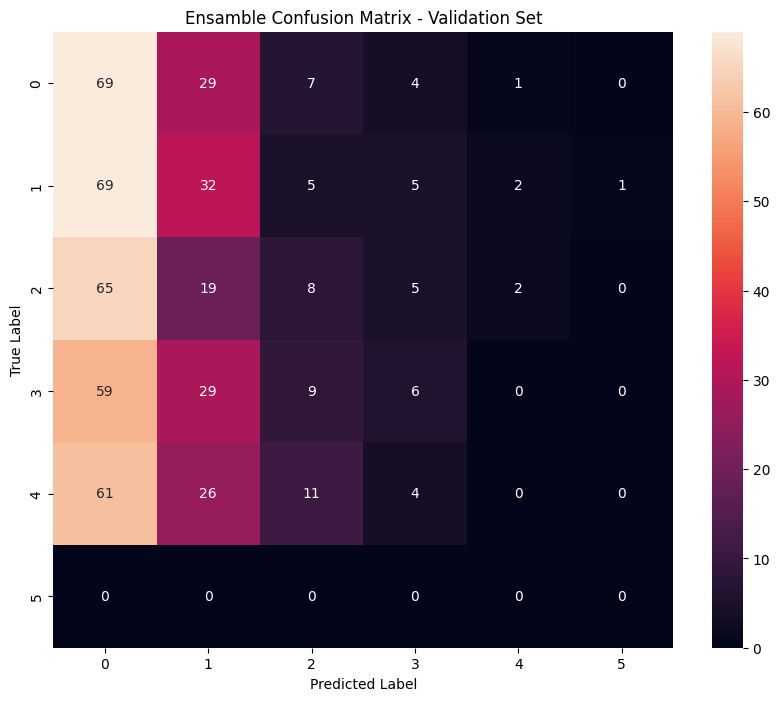

In [18]:
scores = []
for epic in epics:
    net.load_state_dict(epic)
    net.eval()
    valid_predictions = []
    valid_targets = []
    with torch.no_grad():
        for events, targets in valid_loader:
            spk = net(events)
            logits = add_undecided(spk.sum(dim=0))
            predictions = torch.argmax(logits, dim=1)
            valid_predictions += predictions.tolist()
            valid_targets += targets.tolist()
    scores += [(valid_targets, valid_predictions)]

scores = [tuple(torch.mode(torch.tensor(scores), dim=0).values)]

accuracies = [accuracy_score(*score) for score in scores]
print("Accuaracy M:", mean(accuracies))

cm = confusion_matrix(*scores[0])

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Ensamble Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Accuaracy M: 0.18461538461538463


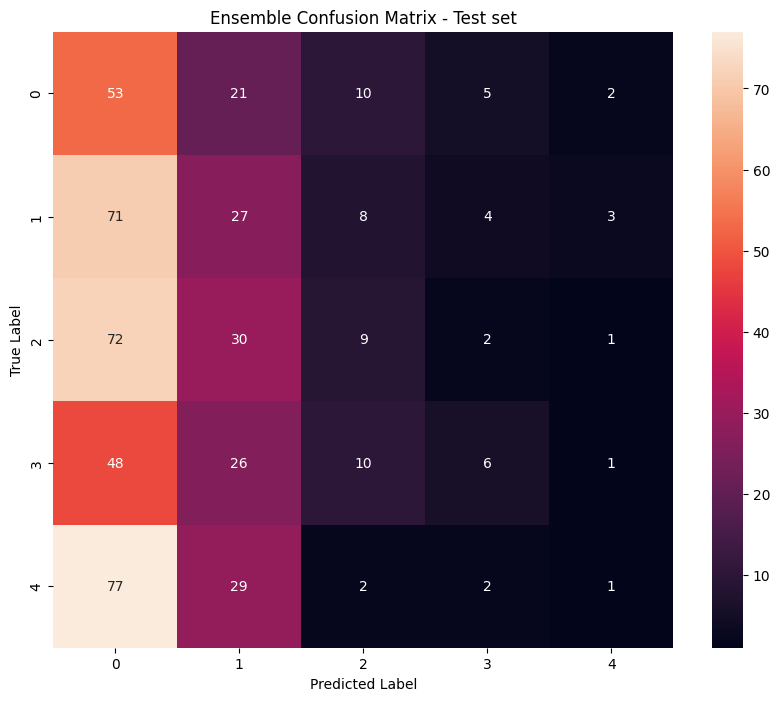

In [19]:
scores = []
for epic in epics:
    net.load_state_dict(epic)
    net.eval()
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for events, targets in test_loader:
            spk = net(events)
            logits = add_undecided(spk.sum(dim=0))
            predictions = torch.argmax(logits, dim=1)
            test_predictions += predictions.tolist()
            test_targets += targets.tolist()
    scores += [(test_targets, test_predictions)]

scores = [tuple(torch.mode(torch.tensor(scores), dim=0).values)]

accuracies = [accuracy_score(*score) for score in scores]
print("Accuaracy M:", mean(accuracies))

cm = confusion_matrix(*scores[0])

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Ensemble Confusion Matrix - Test set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()